In [1]:
# Just a bit of code to run through the HDF5 file and load into a 
# geopandas geodataframe.
#
# Written 5/28/21 by W. Sauthoff (sauthoff@mines.edu)
# Modified 6/8/21 by M. Siegfried (siegfried@mines.edu)

# import packages
from shapely.geometry import asPolygon, MultiPolygon
from pyproj import Geod, CRS, Transformer # for calculating areas

import h5py
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
# import subglacial lake outlines (Siegfried & Fricker, 2018)
h5f = h5py.File('SiegfriedFricker2018-outlines.h5', 'r')
outline_geometries = [] # store polygons
citations = [] # store citation information

# we're going to calculate geodesic lake area because that is often screwed up 
# and occasionally incorrect in the literature
areas = []

# we're going to need to do some coordinate transforms for the geodesic area
# define CRS for Antarcica and make a converter from xy to ll
crs_ll = "EPSG:4326" # wgs84 in lon,lat 
crs_xy = h5f.attrs.get('proj_crs') # get projection from hdf5 file
xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy = True) # make coord transformer
geod = CRS(crs_ll).get_geod() # geod object for calculating area on defined ellipsoid

# look through each lake and load all of it's info
for lake in h5f.keys():
    outline_x = h5f[lake]['x'][:]
    outline_y = h5f[lake]['y'][:]
    outlines_xy = np.stack((outline_x, outline_y),axis=2).reshape(outline_x.shape[1], 2)
    
    # A single lake with multiple polygons is NaN broken---need to identify and
    # load as a MultiPolygon. Otherwise it's easy (just load as polygon)
    if np.isnan(outlines_xy)[:,0].sum() == 0:
        geometry = asPolygon(outlines_xy)
        lon, lat = xy_to_ll.transform(outlines_xy[:,0], outlines_xy[:,1])
        this_area = abs(geod.polygon_area_perimeter(lon,lat)[0])/1e6
    else:
        this_area = 0
        # break at NaN values and load each as separate polygons
        idx = np.where(np.isnan(outlines_xy[:,0]))[0]
        
        # grab outline of first lake before getting into the loop
        this_outline = outlines_xy[0:idx[0],:]
        pgons = [asPolygon(this_outline)] # put the first polygon in a list
        lon,lat = xy_to_ll.transform(this_outline[:,0], this_outline[:,1]) 
        this_area += abs(geod.polygon_area_perimeter(lon,lat)[0])/1e6 # add its area
        for i in np.arange(0,len(idx)):
            if i == len(idx)-1:
                this_outline = outlines_xy[idx[i]+1:,:]
            else:
                this_outline = outlines_xy[idx[i]+1:idx[i+1]]
                
            pgons.append(asPolygon(this_outline))
            lon,lat = xy_to_ll.transform(this_outline[:,0], this_outline[:,1])
            this_area += abs(geod.polygon_area_perimeter(lon,lat)[0])/1e6
        geometry = MultiPolygon(pgons)
        
    # append all the results in the right place
    outline_geometries.append(geometry)
    citations.append(h5f[lake].attrs.get('citation')[0].decode('UTF-8'))
    areas.append(this_area)

# make a pandas dataframe with all the necessary info
df = pd.DataFrame(zip(h5f.keys(), outline_geometries, areas, citations), 
                  columns=['name', 'geometry', 'area (km^2)', 'cite'])
gdf = gpd.GeoDataFrame(df, crs=crs_xy, geometry=outline_geometries)
h5f.close()

(-700000.0, -450000.0)

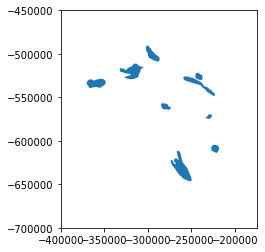

In [3]:
# plot all the lakes and zoom into lower Mercer/Whillans lakes (because we love those lakes)
ax = gdf.plot()
ax.set_xlim(-400000,-175000)
ax.set_ylim(-700000,-450000)

In [9]:
gdf.loc[gdf['name']=='MercerSubglacialLake']

,name,geometry,area (km^2),cite
93,MercerSubglacialLake,"POLYGON ((-299950.018 -500675.034, -299949.971...",143.202974,"Fricker & Scambos, 2009, J. Glac., doi:10.3189..."
